In [142]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


##for dirname, _, filenames in os.walk('/kaggle/input'):
   ## for filename in filenames:
       ## print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from mpl_toolkits.axes_grid1 import ImageGrid
import itertools 
import re
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import numpy as np
import seaborn as sns
from PIL import Image
from tensorflow.keras.layers import Dropout

In [27]:
data_path = '/kaggle/input/dog-breed-identification-data'
train_dir = '/kaggle/input/dog-breed-identification-data/train'
test_dir ='/kaggle/input/dog-breed-identification-data/test'
labels_data = pd.read_csv('/kaggle/input/dog-breed-identification-data/labels.csv')

In [28]:
def append_ext(fn):
    return fn+".jpg"
train_dir = '/kaggle/working/padded_images'
traindf = pd.read_csv('/kaggle/input/dog-breed-identification-data/labels.csv',dtype=str)
testdf = pd.read_csv('/kaggle/input/dog-breed-identification-data/sample_submission.csv',dtype=str)
traindf["id"] = traindf["id"].apply(append_ext)
testdf["id"] = testdf["id"].apply(append_ext)

In [29]:
traindf.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [14]:
traindf.shape


(10222, 2)

In [204]:
testdf.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e.jpg,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,...,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333
1,00102ee9d8eb90812350685311fe5890.jpg,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,...,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333
2,0012a730dfa437f5f3613fb75efcd4ce.jpg,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,...,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333
3,001510bc8570bbeee98c8d80c8a95ec1.jpg,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,...,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333
4,001a5f3114548acdefa3d4da05474c2e.jpg,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,...,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333


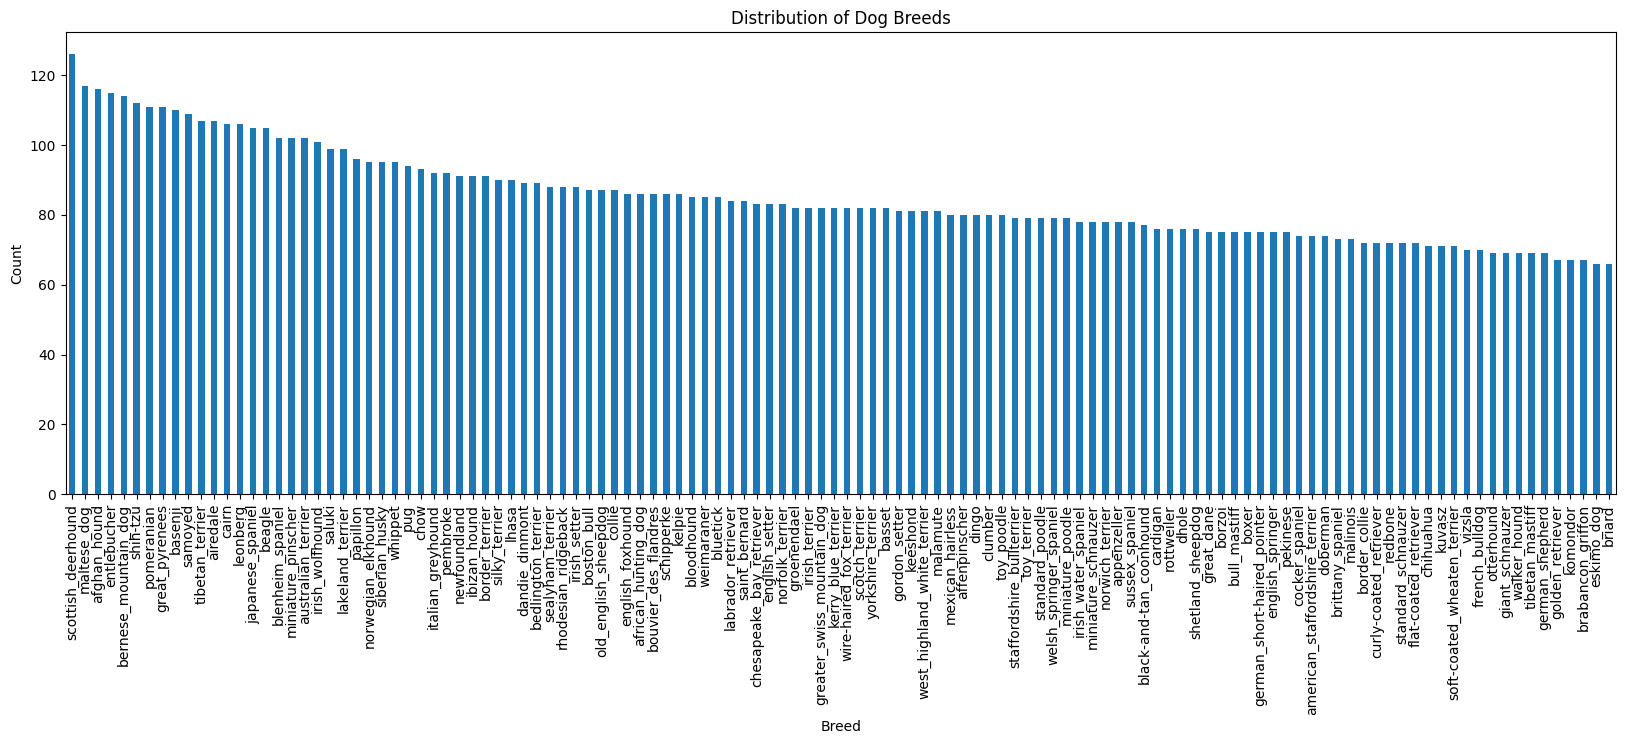

In [15]:

#Explore the Labels
breed_distribution = labels_data['breed'].value_counts()
breed_distribution.plot(kind='bar', figsize=(20, 6))
plt.title('Distribution of Dog Breeds')
plt.xlabel('Breed')
plt.ylabel('Count')
plt.show()

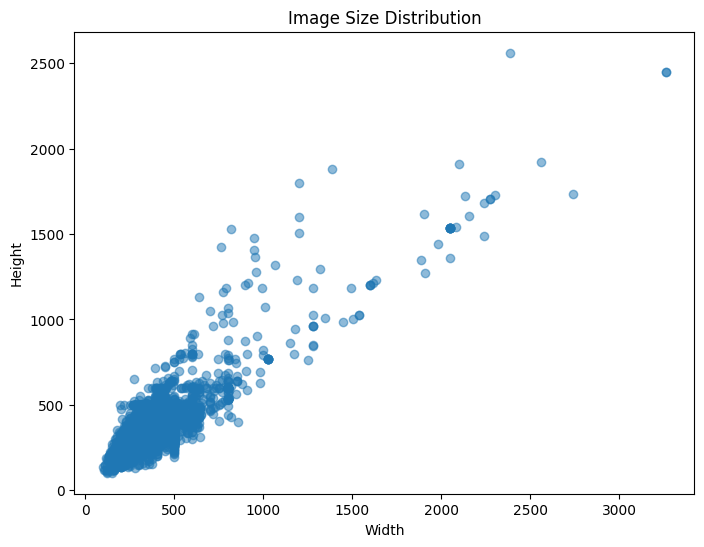

In [16]:
# Assuming images are in the 'train' directory
image_sizes = []

for img_id in labels_data['id'].values:
    img_path = f"/kaggle/input/dog-breed-identification-data/train/{img_id}.jpg"
    img = Image.open(img_path)
    width, height = img.size
    image_sizes.append((width, height))

# Create a DataFrame for image sizes
image_sizes_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])

# Plot image size distribution
plt.figure(figsize=(8, 6))
plt.scatter(image_sizes_df['Width'], image_sizes_df['Height'], alpha=0.5)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Size Distribution")
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


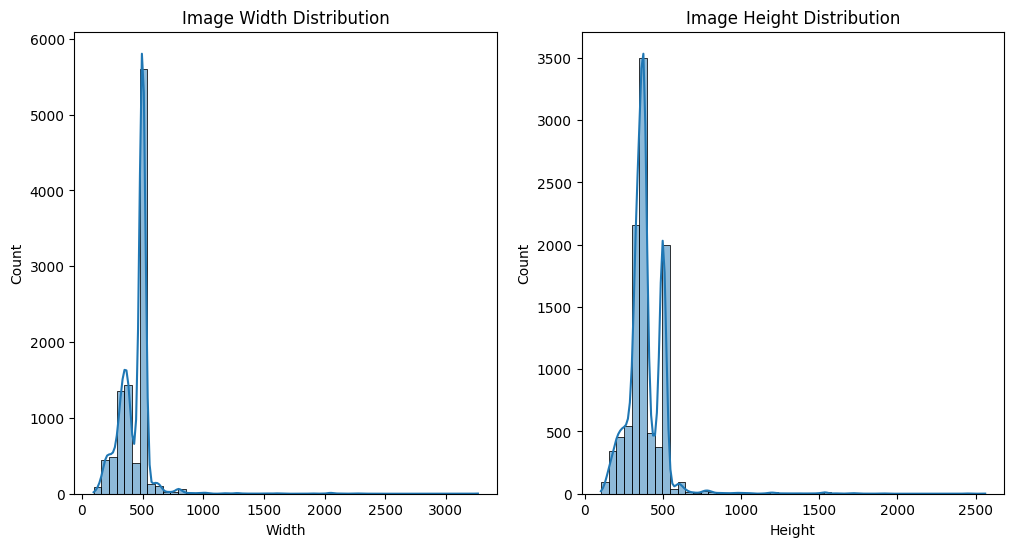

In [17]:
# Plot image size distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(image_sizes_df['Width'], bins=50, kde=True)
plt.title('Image Width Distribution')

plt.subplot(1, 2, 2)
sns.histplot(image_sizes_df['Height'], bins=50, kde=True)
plt.title('Image Height Distribution')

plt.show()


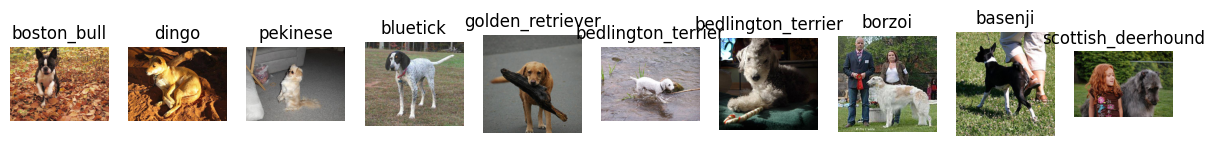

In [18]:
#Visualize Sample Images
def display_sample_images(data, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 8))
    for i in range(num_images):
        img_id = data.iloc[i]['id']
        img_label = data.iloc[i]['breed']
        img_path = os.path.join(data_path, 'train', f'{img_id}.jpg')
        
        # Using PIL for image loading
        img = Image.open(img_path)
        img = img.convert('RGB')
        
        axes[i].imshow(img)
        axes[i].set_title(img_label)
        axes[i].axis('off')
    plt.show()
    
display_sample_images(labels_data)

In [214]:
#image size check
sizes = []
for img_id in labels_data['id']:
    img_path = os.path.join(data_path, 'train', f'{img_id}.jpg')
    img = Image.open(img_path)
    sizes.append(img.size)

In [153]:
#Print unique image sizes
unique_sizes = set(sizes)
print(f"Unique image sizes: {unique_sizes}")

Unique image sizes: {(360, 275), (500, 435), (280, 203), (350, 527), (450, 614), (197, 168), (1200, 1600), (275, 353), (360, 311), (312, 500), (500, 471), (446, 500), (640, 594), (600, 558), (350, 383), (295, 447), (336, 448), (208, 299), (461, 479), (369, 216), (400, 469), (320, 360), (240, 251), (500, 327), (332, 334), (197, 289), (900, 1200), (550, 413), (300, 238), (200, 300), (400, 325), (479, 389), (476, 500), (274, 365), (503, 337), (260, 201), (339, 494), (360, 288), (500, 448), (279, 300), (200, 156), (350, 360), (190, 142), (600, 800), (200, 192), (184, 184), (418, 500), (283, 455), (190, 227), (349, 400), (300, 251), (500, 425), (285, 500), (600, 512), (800, 537), (490, 640), (250, 250), (350, 337), (384, 250), (858, 398), (817, 1529), (513, 480), (364, 500), (191, 200), (500, 281), (498, 500), (263, 225), (255, 221), (294, 441), (294, 212), (320, 350), (447, 391), (600, 404), (389, 715), (295, 293), (142, 200), (315, 500), (550, 403), (200, 290), (400, 315), (500, 402), (39

In [24]:
#padd images for keep aspect ratio

def add_padding_to_images(data_folder, labels_file, output_folder, padding_color=(0, 0, 0)):
    # Read the labels from the CSV file
    labels_data = pd.read_csv(labels_file)
    
    os.makedirs(output_folder, exist_ok=True)

    for index, row in labels_data.iterrows():
        filename = row['id'] + ".jpg"  # Add the file extension
        breed = row['breed']  # Assuming 'breed' is the column containing the class labels

        # Construct the path to the image
        image_path = os.path.join(data_folder, filename)

        # Open the image
        with Image.open(image_path) as img:
            original_size = img.size
            max_size = max(original_size)
            new_size = (max_size, max_size)

            # Create a new image with the desired size and fill it with the padding color
            padded_img = Image.new("RGB", new_size, padding_color)

            # Paste the original image onto the center of the new image
            padded_img.paste(img, ((new_size[0] - original_size[0]) // 2, (new_size[1] - original_size[1]) // 2))

            # Save the padded image back to the original path, overwriting the existing image
            padded_img.save(os.path.join(output_folder, filename))

# Example usage:
data_folder = "/kaggle/input/dog-breed-identification-data/train"
labels_file = "/kaggle/input/dog-breed-identification-data/labels.csv"
output_folder = "/kaggle/working/padded_images"  # Provide the desired output folder
add_padding_to_images(data_folder, labels_file, output_folder)


In [30]:
# Check for missing values
print(labels_data.isnull().sum())

id       0
breed    0
dtype: int64


In [31]:
# Set display option to show all rows
pd.set_option('display.max_rows', None)

# Display all classes and their counts
class_distribution = labels_data['breed'].value_counts()
print("Class Distribution as Numerical Values:")
print(class_distribution)

# Reset display option to default (if needed)
pd.reset_option('display.max_rows')


Class Distribution as Numerical Values:
breed
scottish_deerhound                126
maltese_dog                       117
afghan_hound                      116
entlebucher                       115
bernese_mountain_dog              114
shih-tzu                          112
pomeranian                        111
great_pyrenees                    111
basenji                           110
samoyed                           109
tibetan_terrier                   107
airedale                          107
cairn                             106
leonberg                          106
japanese_spaniel                  105
beagle                            105
blenheim_spaniel                  102
miniature_pinscher                102
australian_terrier                102
irish_wolfhound                   101
saluki                             99
lakeland_terrier                   99
papillon                           96
norwegian_elkhound                 95
siberian_husky                     95
whip

In [33]:
train_datagen=ImageDataGenerator( rescale=1./255.,
                                  #rotation_range = 20,
                                  #brightness_range=[0.2,1.0],
                                  #width_shift_range = 0.2,
                                  #height_shift_range = 0.2,
                                  #shear_range = 0.2,
                                  #zoom_range = [0.7,1],
                                  horizontal_flip = True,
                                  #Setting validation split to 10% 
                                  validation_split=0.1 
                                  )

In [34]:
BATCH_SIZE = 32
image_size=(299,299)

train_generator=train_datagen.flow_from_dataframe(
dataframe=traindf,
directory=train_dir,
x_col="id",
y_col="breed",
subset="training",
batch_size=BATCH_SIZE,
seed=30,
shuffle=True,
class_mode="categorical",
target_size=image_size,
color_mode="rgb" 
)

Found 9200 validated image filenames belonging to 120 classes.


In [35]:
x,y = next(train_generator)
print(type(x))
print(x.shape)
print(y.shape)


<class 'numpy.ndarray'>
(32, 299, 299, 3)
(32, 120)


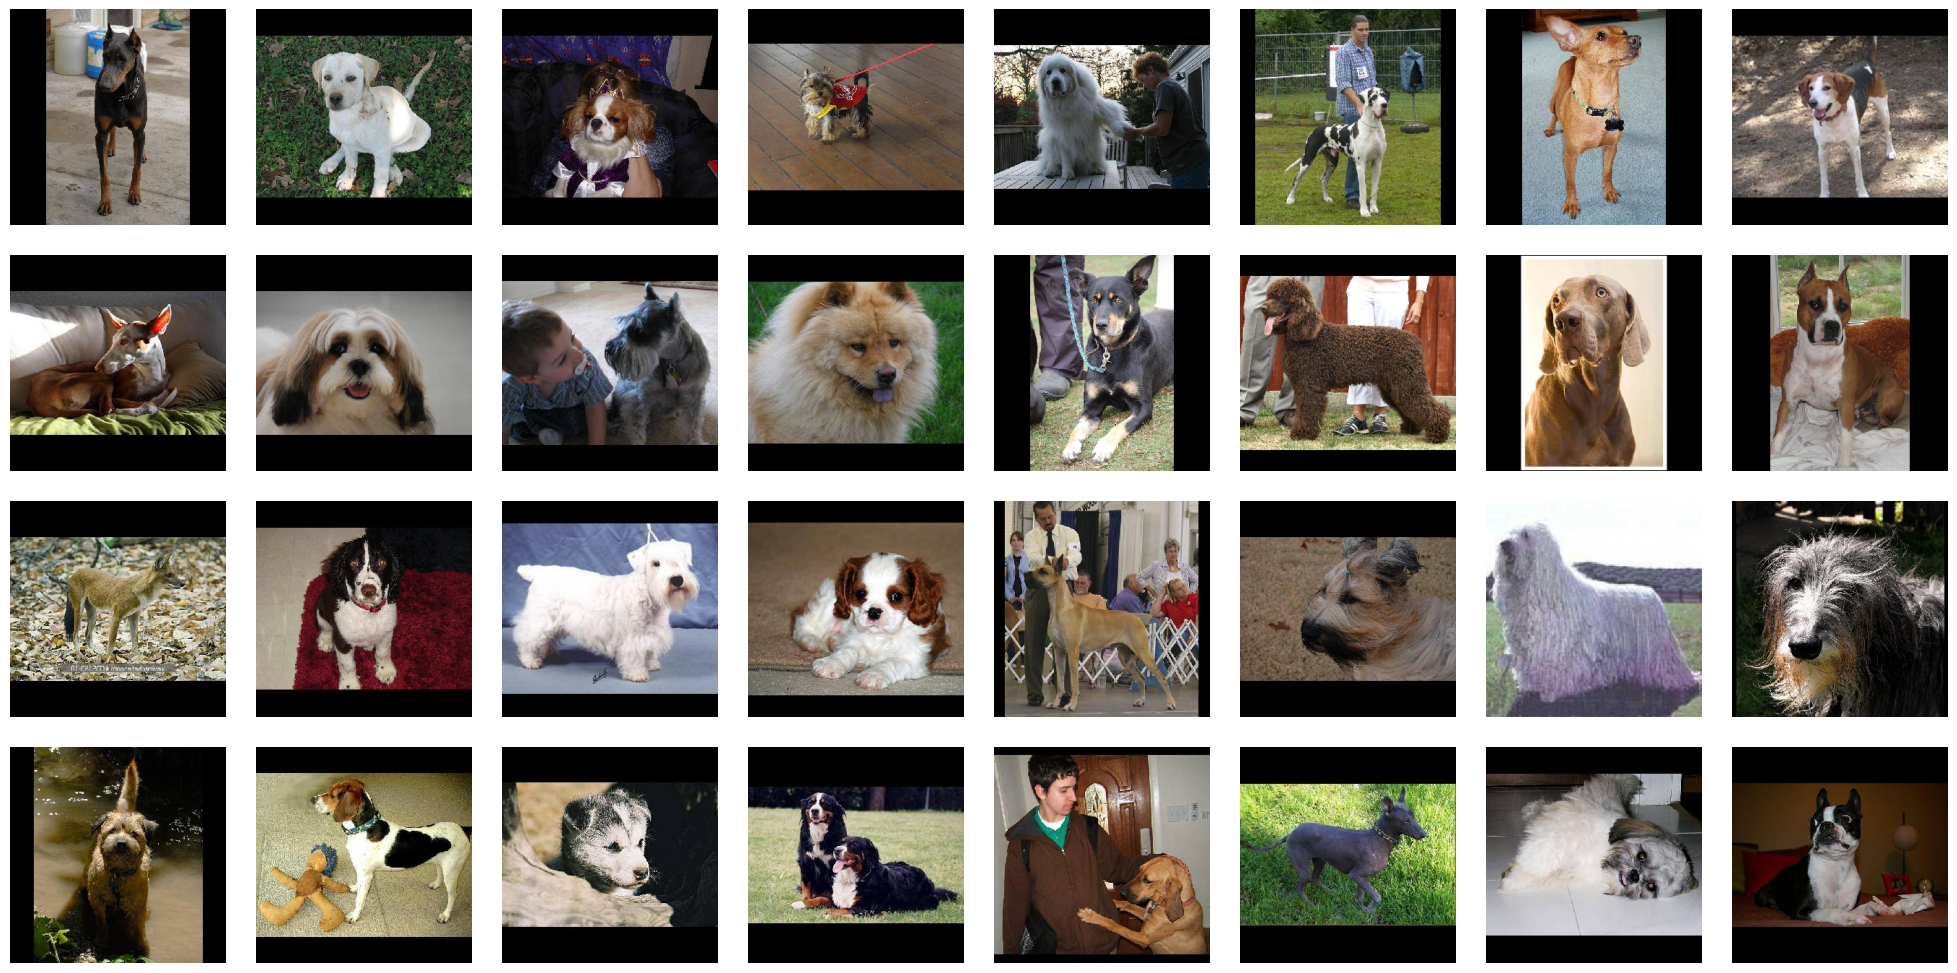

In [36]:
def show_grid(image_list,nrows,ncols,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        

show_grid(x,4,8,figsize=(25,25))




In [37]:


valid_generator=train_datagen.flow_from_dataframe(
dataframe=traindf,
directory=train_dir,
x_col="id",
y_col="breed",
subset="validation",
batch_size=BATCH_SIZE,
seed=30,
shuffle=True,
class_mode="categorical",
target_size=image_size,
color_mode="rgb")



Found 1022 validated image filenames belonging to 120 classes.


In [38]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf,
directory=test_dir,
x_col="id",
y_col=None,
batch_size=BATCH_SIZE,
seed=30,
shuffle=False,
class_mode=None,
target_size=image_size,
color_mode="rgb")

Found 10357 validated image filenames.


In [39]:
shape=[299,299,3]

base_model = tf.keras.applications.InceptionV3(
        weights='imagenet',
        include_top=False ,
        input_shape=shape
    )
base_model.trainable = False
    
model = tf.keras.Sequential([ 
        base_model,   
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(120, activation='softmax')
    ])



87910968/87910968 [==============================] - 0s 0us/step


In [40]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
opt=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(optimizer = opt ,
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               30840     
                                                                 
Total params: 22358168 (85.29 MB)
Trainable params: 555384 (2.12 MB)
Non-trainable params: 21802784 (83.17 MB)
___________

In [41]:
from sklearn.utils.class_weight import compute_class_weight

reduce = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',factor=0.2,patience=5, min_lr=0.001 )

early = tf.keras.callbacks.EarlyStopping( patience=2,
                                          min_delta=0.001,
                                          restore_best_weights=True)
class_weights = compute_class_weight('balanced', classes=np.unique(traindf['breed']), y=traindf['breed'])




In [42]:
print(class_weights)


[1.06479167 0.73433908 0.99050388 0.79610592 1.15112613 1.09209402
 0.83513072 0.77439394 1.03882114 0.81126984 0.9571161  0.74722222
 1.10627706 0.83513072 1.00215686 1.00215686 1.18310185 0.93608059
 1.13577778 0.97911877 0.99050388 1.13577778 1.27139303 1.29065657
 1.16689498 1.13577778 0.80361635 1.12083333 1.02630522 1.19976526
 0.91594982 1.06479167 1.15112613 0.97911877 1.18310185 0.9571161
 1.12083333 1.06479167 1.15112613 0.99050388 1.02630522 1.13577778
 0.74072464 1.29065657 1.18310185 1.21690476 1.23454106 1.13577778
 1.23454106 1.27139303 1.05164609 1.13577778 0.76741742 1.03882114
 1.03882114 0.93608059 0.96799242 1.03882114 1.09209402 0.84339934
 0.9259058  0.81126984 1.05164609 0.99050388 1.03882114 1.27139303
 1.19976526 1.0140873  0.86043771 0.80361635 0.94648148 1.05164609
 1.16689498 0.72806268 1.06479167 0.83513072 1.07827004 1.09209402
 0.93608059 1.02630522 0.89666667 1.09209402 0.97911877 1.23454106
 0.88732639 1.13577778 0.9259058  0.76741742 0.90620567 1.18310

In [43]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10,
                    callbacks=[early],
                    class_weight=dict(enumerate(class_weights)))


model.save('/kaggle/working/inceptionv3_finetuned2.h5')


Epoch 1/10


I0000 00:00:1708855750.378554     219 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


287/287 [==============================] - 60s 177ms/step - loss: 2.3360 - accuracy: 0.5002 - val_loss: 0.6944 - val_accuracy: 0.8004
Epoch 2/10
287/287 [==============================] - 47s 164ms/step - loss: 0.8273 - accuracy: 0.7713 - val_loss: 0.5739 - val_accuracy: 0.8367
Epoch 3/10
287/287 [==============================] - 48s 166ms/step - loss: 0.6669 - accuracy: 0.8074 - val_loss: 0.5310 - val_accuracy: 0.8337
Epoch 4/10
287/287 [==============================] - 47s 164ms/step - loss: 0.6055 - accuracy: 0.8213 - val_loss: 0.5112 - val_accuracy: 0.8357
Epoch 5/10
287/287 [==============================] - 48s 167ms/step - loss: 0.5483 - accuracy: 0.8345 - val_loss: 0.5280 - val_accuracy: 0.8306
Epoch 6/10
287/287 [==============================] - 47s 164ms/step - loss: 0.5066 - accuracy: 0.8460 - val_loss: 0.5331 - val_accuracy: 0.8327


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [44]:
from IPython.display import FileLink

# Replace 'my_trained_model.h5' with your actual model file name
output_path = r'/kaggle/working/inceptionv3_finetuned2.h5'

# Create a download link
FileLink(r'./' + output_path.split('/')[-1])

/kaggle/working/inceptionv3_finetuned2.h5

In [ ]:
import pickle

# Save the model
with open('/kaggle/working/inceptionv3_finetuned.pickle', 'wb') as file:
    pickle.dump(model, file)



/tmp/ipykernel_34/494254271.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


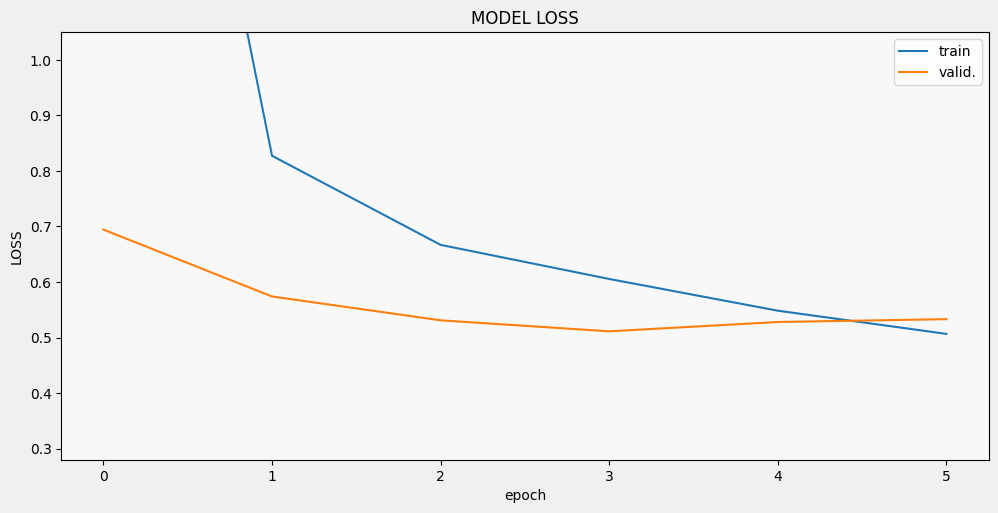

In [45]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('MODEL '+ title)
    ax.set_ylabel(title)
    ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])


display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'LOSS',
    211,
)


/tmp/ipykernel_34/494254271.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


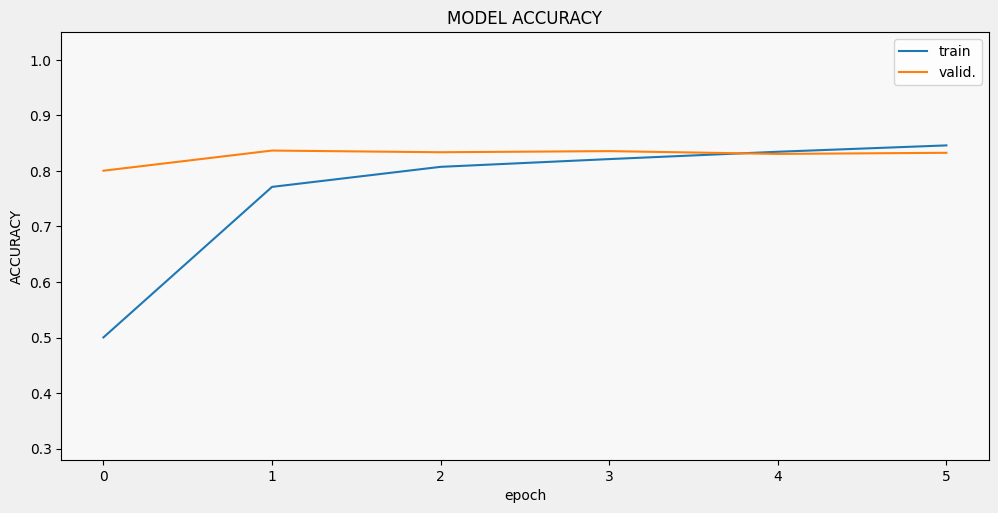

In [46]:

display_training_curves(
    history.history['accuracy'],
    history.history['val_accuracy'],
    'ACCURACY',
    211,
)




In [47]:
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score

# Function to preprocess image for validation
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.  # Rescale to [0,1]
    return img_array

# Get file paths and true labels for validation data
valid_file_paths = valid_generator.filepaths
true_labels = valid_generator.classes

# Preprocess images and get predictions
predicted_labels = []

for img_path in valid_file_paths:
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    predicted_label = np.argmax(prediction)
    predicted_labels.append(predicted_label)

# Convert predicted labels to numpy array
predicted_labels = np.array(predicted_labels)

# Get class labels from generator
class_labels = list(valid_generator.class_indices.keys())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Generate classification report
class_report = classification_report(true_labels, predicted_labels, target_names=class_labels)

# Calculate and print F1 score, precision, and recall
f1_score_value = f1_score(true_labels, predicted_labels, average='weighted')
precision_value = precision_score(true_labels, predicted_labels, average='weighted')
recall_value = recall_score(true_labels, predicted_labels, average='weighted')

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)
print("\nF1 Score: {:.4f}".format(f1_score_value))
print("Precision: {:.4f}".format(precision_value))
print("Recall: {:.4f}".format(recall_value))


1/1 [==============================] - 0s 23ms/step
Confusion Matrix:
[[ 9  0  0 ...  0  0  0]
 [ 0 11  0 ...  0  0  0]
 [ 0  0 11 ...  0  0  0]
 ...
 [ 0  0  0 ...  8  0  0]
 [ 0  0  0 ...  0  5  0]
 [ 0  0  0 ...  0  0  3]]

Classification Report:
                                precision    recall  f1-score   support

                 affenpinscher       0.90      0.90      0.90        10
                  afghan_hound       1.00      0.85      0.92        13
           african_hunting_dog       1.00      1.00      1.00        11
                      airedale       0.67      0.80      0.73        10
american_staffordshire_terrier       0.67      0.29      0.40         7
                   appenzeller       0.50      0.75      0.60         8
            australian_terrier       0.62      0.80      0.70        10
                       basenji       0.85      0.79      0.81        14
                        basset       0.86      1.00      0.92        12
                        beagl

In [235]:
pred=model.predict(test_generator)

324/324 [==============================] - 113s 346ms/step


In [236]:
df_submission = pd.read_csv('/kaggle/input/dog-breed-identification-data/sample_submission.csv')
df_submission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [239]:
file_list = test_generator.filenames
id_list = []
for name in file_list:
    m = re.sub('test/', '', name)
    m = re.sub('.jpg', '', m)
    id_list.append(m)

In [240]:
df_submission['id'] = id_list
df_submission.iloc[:,1:] = pred
df_submission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.000003,1.315963e-07,3.990266e-07,5.930413e-08,5.633062e-07,1.550645e-07,1.156404e-07,3.633364e-08,8.797946e-08,...,4.187625e-07,1.683401e-05,1.528954e-06,1.127867e-07,6.507162e-08,3.779973e-07,2.116657e-07,7.291875e-08,2.414747e-06,9.667258e-07
1,00102ee9d8eb90812350685311fe5890,0.000002,6.120616e-07,1.074833e-06,1.696510e-07,2.482038e-06,3.475249e-06,3.424421e-07,4.045417e-06,6.165297e-07,...,1.168344e-06,2.891268e-07,9.444529e-07,8.183465e-07,5.993035e-07,1.881765e-06,2.814940e-05,5.228786e-06,9.478060e-07,1.430431e-06
2,0012a730dfa437f5f3613fb75efcd4ce,0.000013,1.555493e-02,1.123076e-04,1.752040e-04,1.430240e-05,4.652762e-05,1.606632e-05,3.120879e-05,1.686080e-05,...,3.034302e-05,6.775309e-05,5.573361e-05,3.619929e-04,6.399360e-05,5.553746e-03,1.692237e-05,9.760475e-04,1.258499e-04,3.473586e-05
3,001510bc8570bbeee98c8d80c8a95ec1,0.000422,6.922111e-06,1.209583e-05,9.631553e-07,2.536592e-04,2.648258e-05,4.336628e-06,4.129449e-06,2.528531e-05,...,3.904522e-05,1.448286e-05,8.302662e-06,3.433969e-06,2.525432e-05,1.302434e-05,1.872122e-05,1.196776e-05,3.079062e-06,8.661069e-06
4,001a5f3114548acdefa3d4da05474c2e,0.026141,1.796952e-04,9.276087e-06,4.539268e-06,3.921314e-05,1.215030e-05,5.271811e-05,1.347019e-05,5.680797e-05,...,5.636115e-05,9.002228e-05,1.379584e-04,2.241717e-05,2.748283e-05,3.442247e-05,1.356682e-05,1.599621e-05,2.439410e-04,4.995239e-04


In [241]:
final_sub = df_submission.set_index('id')
final_sub.to_csv('Submission.csv')

In [ ]:
from IPython.display import FileLink

# Replace 'my_trained_model.h5' with your actual model file name
output_path = r'/kaggle/working/Submission.csv'

# Create a download link
FileLink(r'./' + output_path.split('/')[-1])